In [2]:
import torch
from torch.optim.lr_scheduler import StepLR
from torch.nn import MSELoss
from src.spaces.sphere import Sphere
from src.spaces.grassmannian import Grassmannian, OrientedGrassmannian
from src.spectral_kernel import EigenbasisSumKernel
from src.prior_approximation import RandomPhaseApproximation
from src.spectral_measure import MaternSpectralMeasure, SqExpSpectralMeasure
from examples.gpr_model import ExactGPModel, train
import matplotlib.pyplot as plt
import numpy as np
import gpytorch
import os
import sys

In [3]:
sys.setrecursionlimit(2000)
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
torch.autograd.set_detect_anomaly(True)
dtype = torch.float64
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#torch.cuda.set_per_process_memory_fraction(0.9, 0)
#torch.cuda.empty_cache()
%matplotlib widget

In [4]:
def sphere_grid(r=1., nlats=41, nlons=41, center=None):
    if center is None:
        center = np.r_[0, 0, 0]
    phi, theta = np.mgrid[0:np.pi:nlats*1j, 0:2 * np.pi:nlons*1j]

    x = r * np.sin(phi) * np.cos(theta) + center[0]
    y = r * np.sin(phi) * np.sin(theta) + center[1]
    z = r * np.cos(phi) + center[2]

    return torch.tensor(x, device=device, dtype=dtype), \
           torch.tensor(y, device=device, dtype=dtype),\
           torch.tensor(z, device=device, dtype=dtype)

def plot_sphere(x, y, z, c):
    x_, y_, z_, c_ = x.detach().cpu(), y.detach().cpu(), z.detach().cpu(), c.detach().cpu()
    cmap = plt.get_cmap('plasma')
    ax=plt.subplot(111, projection='3d')
    surf = ax.plot_surface(x_, y_, z_,
                           cstride=1, rstride=1,
                           cmap=cmap,
                           facecolors=cmap(c_))
    plt.show()
    #ax.set_axis_off()

In [5]:
order = 10
sphere = Sphere(n=2, order=order)

In [6]:
lengthscale, nu, variance = 0.25, 5.0 + sphere.dim, 3
measure = SqExpSpectralMeasure(sphere.dim, lengthscale, variance)
#self.measure = MaternSpectralMeasure(self.space.dim, self.lengthscale, self.nu)

In [7]:
sphere_kernel = EigenbasisSumKernel(measure=measure, manifold=sphere)
sphere_sampler = RandomPhaseApproximation(kernel=sphere_kernel, phase_order=10**2)

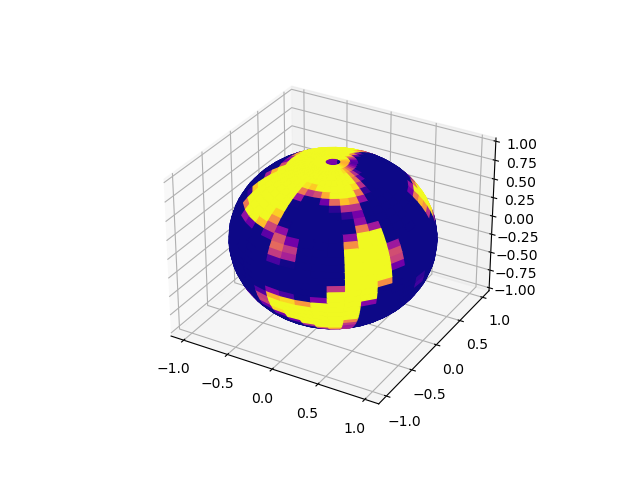

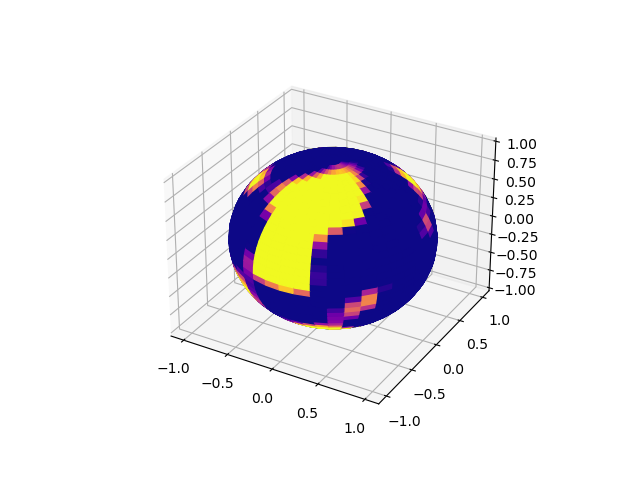

tensor(-3.5863, device='cuda:0', dtype=torch.float64, grad_fn=<MinBackward1>) tensor(4.0119, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)


In [8]:
x, y, z = sphere_grid()
points = torch.stack((x,y,z), dim=-1).reshape(-1, 3)
sphere_samples = sphere_sampler(points).reshape(x.shape[0], x.shape[1])
plot_sphere(x, y, z, sphere_samples)
plot_sphere(-x, -y, -z, sphere_samples)
print(torch.min(sphere_samples), torch.max(sphere_samples))

torch.Size([1681, 3, 1])


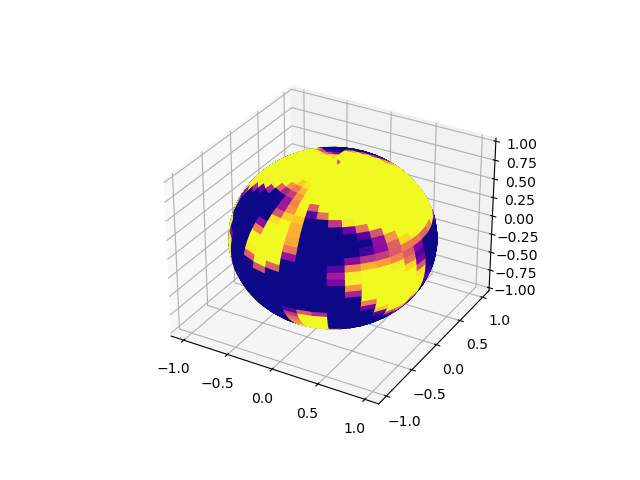

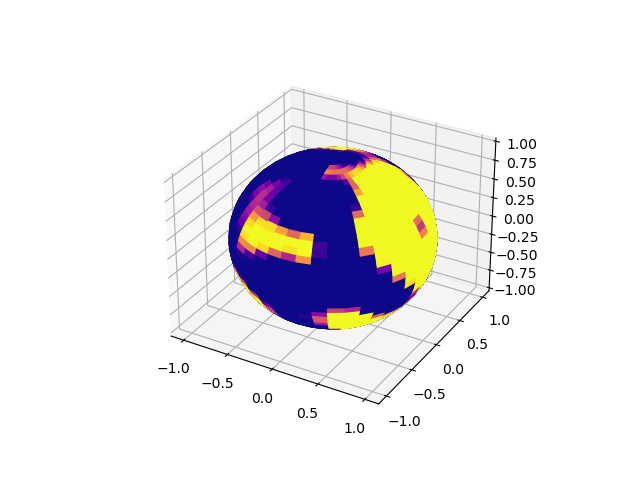

In [9]:
points_ = torch.unsqueeze(points, -1)
print(points_.shape)

#grassmannian = Grassmannian(3,1, order=10, average_order=20)
grassmannian = OrientedGrassmannian(3,1, order=10, average_order=100)
grassmannian_kernel = EigenbasisSumKernel(measure=measure, manifold=grassmannian)
grassmannian_sampler = RandomPhaseApproximation(kernel=grassmannian_kernel, phase_order=100)

grassmannian_samples = grassmannian_sampler(points_).reshape(x.shape[0], x.shape[1])
plot_sphere(x, y, z, grassmannian_samples)
plot_sphere(-x,-y,-z, grassmannian_samples)

In [10]:
print(torch.max(grassmannian_samples), torch.min(grassmannian_samples))

tensor(5.6617, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>) tensor(-3.7819, device='cuda:0', dtype=torch.float64, grad_fn=<MinBackward1>)


In [11]:
rand_x = sphere.rand(50)
rand_x_ = torch.unsqueeze(rand_x, -1)
cov_grassmanian = grassmannian_kernel(rand_x_, rand_x_)
cov_sphere = sphere_kernel(rand_x, rand_x)
print(torch.max(torch.abs(cov_grassmanian-cov_sphere)))

tensor(2.0922, device='cuda:0', dtype=torch.float64, grad_fn=<MaxBackward1>)
